In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

import matplotlib.patches as patches

In [2]:
H = 40
W = 40
h = H-1
w = W-1

n_min = 2
n_max = 5

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.73818459 0.875      0.10308571 0.10308571]
 [0.33553547 0.625      0.15775416 0.15775416]
 [0.42338477 0.375      0.21544618 0.21544618]
 [0.41373709 0.125      0.144271   0.14871047]]
[2. 1. 1. 0.]


In [3]:
anchor_boxes = np.array([
    [0.3,0.3],
    [0.2,0.2],
    [0.1,0.1],
    [0.05,0.05],
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = j/(W-1)
        anchors[i,j,:,1] = i/(H-1)
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

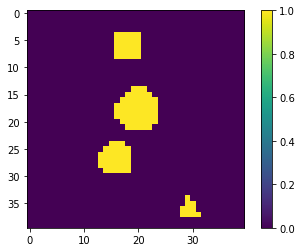

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain     = 10000
lr         = 0.0001
print_step = 1000

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,1], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=1, output_size=64)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=64, 
                   window_size=20, hidden_size=256)

rcnn     = net.RCNN(backbone, rpn, anchors, backbone_channels=1, 
                   window_size=10, hidden_size=256, num_classes=3, obj_threshold=0.8, scope='rcnn')


crop_conv = rcnn(x_tf)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_sum(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = 10*tf.reduce_sum(y_weights_tf*y_label_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

lab_sum = tf.reduce_sum(y_label_tf)

loss = loss_class+loss_box

print(loss_class, loss_box, loss)

W0815 16:00:04.737293 140121516545792 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0815 16:00:04.739371 140121516545792 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/rcnn/net.py:14: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0815 16:00:04.740604 140121516545792 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0815 16:00:04.871448 140121516545792 deprecation.py:323] From /home/marsdenlab/anaconda3/lib/python3.6/site-packages/tens

Tensor("Sum_1:0", shape=(), dtype=float32) Tensor("mul_7:0", shape=(), dtype=float32) Tensor("add_2:0", shape=(), dtype=float32)


In [7]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_box, gt_label = shapes.shapes_to_gt(shap)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l,lc,lb,ls = sess.run([loss, loss_class, loss_box, lab_sum], {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.3f} loss_class={:.3f} loss_box={:.3f}, lab_sum={:.1f}".format(i,l, lc, lb, ls))

iteration 0: loss=4337.894 loss_class=4321.539 loss_box=16.355, lab_sum=17.0
iteration 1000: loss=6.291 loss_class=3.621 loss_box=2.670, lab_sum=16.0
iteration 2000: loss=13.046 loss_class=4.556 loss_box=8.489, lab_sum=27.0
iteration 3000: loss=2.233 loss_class=0.696 loss_box=1.537, lab_sum=25.0


In [10]:
x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)

gt_t, gt_matched, gt_labels, gt_weights =\
box.create_box_gt(anchors_1d, gt_box)

x = x.reshape((1,H,W,1))

out_box, l_box, out_obj = sess.run([rpn_box, list_box, rpn_obj], {x_tf:x})

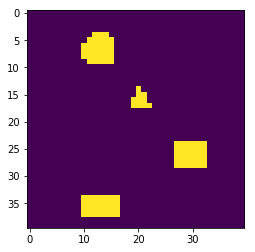

0


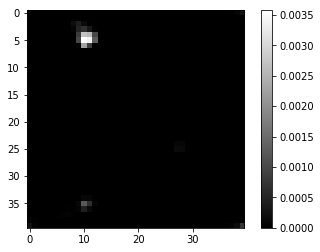

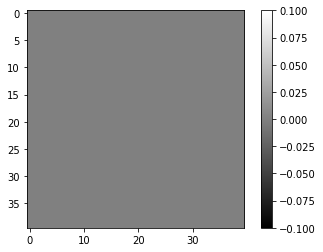

1


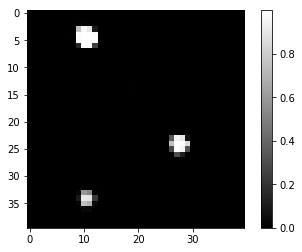

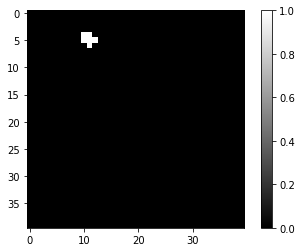

2


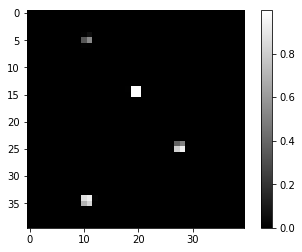

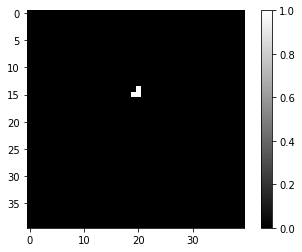

3


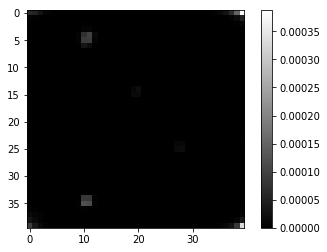

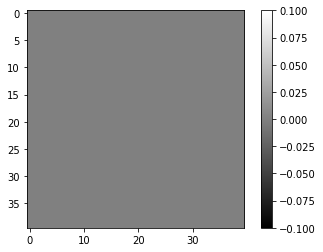

weights
0


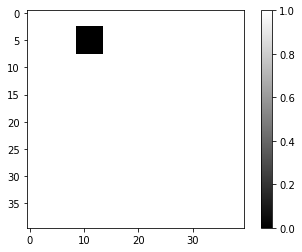

1


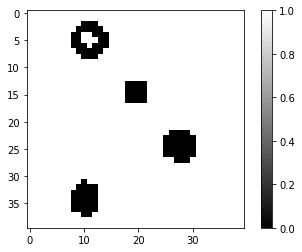

2


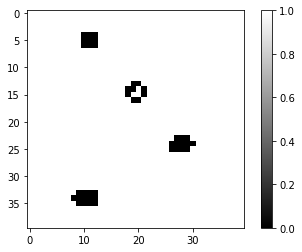

3


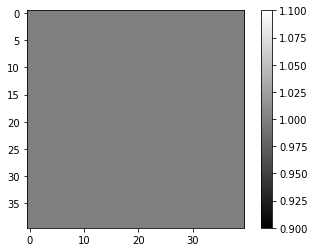

In [11]:
lab = gt_labels.reshape((H,W,K))
weights = gt_weights.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
print("weights")
for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(weights[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()

In [12]:
predicted_boxes, predicted_obj = sess.run([list_box, list_obj],{x_tf:x})

In [18]:
anch_p = anchors.reshape((-1,4))[predicted_obj>0.9]
print(anch_p)

[[0.25641026 0.07692308 0.2        0.2       ]
 [0.23076923 0.1025641  0.2        0.2       ]
 [0.25641026 0.1025641  0.2        0.2       ]
 [0.28205128 0.1025641  0.2        0.2       ]
 [0.30769231 0.1025641  0.2        0.2       ]
 [0.23076923 0.12820513 0.2        0.2       ]
 [0.25641026 0.12820513 0.2        0.2       ]
 [0.28205128 0.12820513 0.2        0.2       ]
 [0.30769231 0.12820513 0.2        0.2       ]
 [0.25641026 0.15384615 0.2        0.2       ]
 [0.28205128 0.15384615 0.2        0.2       ]
 [0.48717949 0.35897436 0.1        0.1       ]
 [0.51282051 0.35897436 0.1        0.1       ]
 [0.48717949 0.38461538 0.1        0.1       ]
 [0.51282051 0.38461538 0.1        0.1       ]
 [0.69230769 0.58974359 0.2        0.2       ]
 [0.71794872 0.58974359 0.2        0.2       ]
 [0.69230769 0.61538462 0.2        0.2       ]
 [0.71794872 0.61538462 0.2        0.2       ]
 [0.69230769 0.64102564 0.2        0.2       ]
 [0.71794872 0.64102564 0.2        0.2       ]
 [0.71794872 

In [19]:
bp = predicted_boxes[predicted_obj>0.9]
print(bp)

[[ 1.04650371e-01  2.54620135e-01 -1.14795543e-01 -1.40320867e-01]
 [ 2.04235762e-01  1.29628152e-01 -1.09379575e-01 -1.38713583e-01]
 [ 1.12721346e-01  1.36071399e-01 -1.65248856e-01 -1.65244132e-01]
 [-2.91603692e-02  1.29450530e-01 -1.71045199e-01 -1.77731276e-01]
 [-1.24377869e-01  1.15189806e-01 -1.09769113e-01 -1.29420772e-01]
 [ 1.86802238e-01  1.40530604e-03 -8.91579911e-02 -1.06252104e-01]
 [ 1.14604153e-01 -8.87607317e-03 -1.89697996e-01 -1.88726097e-01]
 [-2.40672827e-02 -8.34648591e-03 -1.89000651e-01 -1.89403623e-01]
 [-1.23971619e-01 -2.16199644e-02 -1.12817131e-01 -1.03784747e-01]
 [ 8.87386650e-02 -1.44231901e-01 -1.04836933e-01 -1.21283002e-01]
 [ 1.93135329e-05 -1.48086727e-01 -9.41988230e-02 -1.27217621e-01]
 [ 1.05610520e-01  8.08041766e-02  1.25004843e-01  1.52470544e-01]
 [-6.01961687e-02  8.04273486e-02  1.37242064e-01  1.38969287e-01]
 [ 8.89397562e-02 -1.61606267e-01  7.87376538e-02  1.22865185e-01]
 [-8.25540051e-02 -1.58637986e-01  1.18859477e-01  1.27121180e

In [20]:
gt_p = gt_t[predicted_obj>0.9]
print(gt_p)

[[ 0.11449857  0.24038462 -0.16198315 -0.16198315]
 [ 0.24270369  0.11217949 -0.16198315 -0.16198315]
 [ 0.11449857  0.11217949 -0.16198315 -0.16198315]
 [-0.01370656  0.11217949 -0.16198315 -0.16198315]
 [-0.14191169  0.11217949 -0.16198315 -0.16198315]
 [ 0.24270369 -0.01602564 -0.16198315 -0.16198315]
 [ 0.11449857 -0.01602564 -0.16198315 -0.16198315]
 [-0.01370656 -0.01602564 -0.16198315 -0.16198315]
 [-0.14191169 -0.01602564 -0.16198315 -0.16198315]
 [ 0.11449857 -0.14423077 -0.16198315 -0.16198315]
 [-0.01370656 -0.14423077 -0.16198315 -0.16198315]
 [ 0.15731738  0.16025641  0.1386624   0.1386624 ]
 [-0.09909287  0.16025641  0.1386624   0.1386624 ]
 [ 0.15731738 -0.09615385  0.1386624   0.1386624 ]
 [-0.09909287 -0.09615385  0.1386624   0.1386624 ]
 [ 0.08224408  0.17628205 -0.16091054 -0.44615084]
 [-0.04596105  0.17628205 -0.16091054 -0.44615084]
 [ 0.08224408  0.04807692 -0.16091054 -0.44615084]
 [-0.04596105  0.04807692 -0.16091054 -0.44615084]
 [ 0.08224408 -0.08012821 -0.16

In [21]:
bp_n = box.inv_bbox_transform(anch_p, bp)
gt_n = box.inv_bbox_transform(anch_p, gt_p)
print(bp_n*H)
print(gt_n*H)
print(gt_box*H)

[[11.09361322  5.11388416  7.13238716  6.95263481]
 [10.86465533  5.13958932  7.17112064  6.96381855]
 [11.15818103  5.19113529  6.78146172  6.78149366]
 [11.04876833  5.13816834  6.74226761  6.69733906]
 [11.31266936  5.02408255  7.16832781  7.02883339]
 [10.72518714  5.13944758  7.31760836  7.19358349]
 [11.17324348  5.05719654  6.61767149  6.62410593]
 [11.08951302  5.06143324  6.62228775  6.61961985]
 [11.31591936  4.95524541  7.14651203  7.21135426]
 [10.96631958  4.99999095  7.20377064  7.08626604]
 [11.28220579  4.96915234  7.28081417  7.04433632]
 [19.90962157 14.68219107  4.53261566  4.65883255]
 [20.27203584 14.68068375  4.58842325  4.59635544]
 [19.84293851 14.73819032  4.32768202  4.52292776]
 [20.18260449 14.75006344  4.50484657  4.54221869]
 [28.55338977 25.3436732   7.41440582  5.93700647]
 [28.63242676 25.23429582  7.56597424  5.98562002]
 [28.43378029 25.25073252  6.73010492  5.82168531]
 [28.43861599 25.17401395  6.78002644  5.82197714]
 [28.38185726 25.24251751  6.72

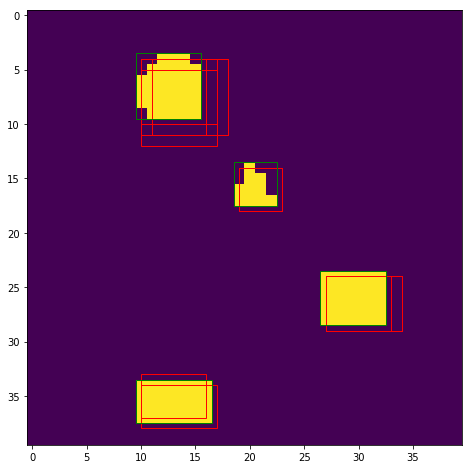

In [22]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(8,8))

# Display the image
ax.imshow(x[0,:,:,0])

# Create a Rectangle patch
for b in bp_n:
    rect = patches.Rectangle((int(b[0]*w),int(b[1]*h)),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Create a Rectangle patch
for b in gt_box:
    rect = patches.Rectangle((int(b[0]*w)-0.5,int(b[1]*h)-0.5),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()